In [2]:
from analyzer import PITCHfx, GameLogs, PlayerMap, EventInfo, Parks
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np
pd.set_option("max_columns",100)

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_season(year, pitcher):
    """
    Args:
        year and pitcher (or list of pitchers) to extract pitchf/x data from
        
    Returns:
        pfx object with dataframe
    """
    
    ## combine PITCHfx and GameLogs for ease of analysis
    pfx = PITCHfx(year)+GameLogs(year)+EventInfo(year)+Parks()

    ## get name maps and merge with dataframe
    PM = PlayerMap()
    pfx.df['mlb_id'] = pfx.df['pitcher']
    PM.slim_frame(['mlb_id','retro_id','retro_name'])
    pfx = pfx+PM

    ## filter on pitcher retro id
    pfx.filter_by_pitchers(pitcher)
    return pfx

In [4]:
## year and pitcher to analyze
#year = 2017
pitcher = 'lestj001'

#pfx = get_season(year, pitcher)
#pfx.add_time_stamp()

In [5]:
pfx = sum([get_season(year, pitcher) for year in range(2010,2018)])

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (12,16) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
## add time stamps
pfx.add_time_stamp()

## not interested in Pitch out or "IN"
pfx.df = pfx.df[(pfx.df.pitch_type!='PO') & (pfx.df.pitch_type!='IN')]

In [7]:
def box_plots(x, y, hue, data, kind='box'):
    """
    Makes box (or violin) style plots with a variety of groupings
    Args:
         x = some way of grouping data (e.g. month, year, pitcher, etc.)
         y = distribution to create box plots on
         hue = sub grouping within x (e.g. pitch_type)
         kind = box, violin, etc. defaults to box
    """
    ## set the font
    tmp = plt.rc('font', size=16)

    ## force y to be a list for iteration
    if type(y)==str:
        y = [y]
    
    fig, axes = plt.subplots(len(y), sharex=True, figsize=(15,7*len(y)))
    
    ## make axes iterable if y has length of 1
    if len(y)==1:
        axes=(axes,)
        
    ## use seaborn to build box plots
    for y_var, ax in zip(y, axes):
        g = sns.catplot(x=x, y=y_var, hue=hue, kind=kind, data=data, ax=ax)
        ## close the catplot to avoid duplication
        plt.close(g.fig)

    # extend x axis to make room for legend
    lo,hi = ax.get_xlim()
    ax.set_xlim(lo,hi+1)

    #title
    if x=='month':
        fig.suptitle(data.retro_name.unique()[0]+" "+str(year), va='bottom')
    else:
        fig.suptitle(','.join(data.retro_name.unique()), y=0.93)
    ## move title closer to plot
    fig.subplots_adjust(hspace=0)

    ## 
    str(list(ax.get_xticklabels())[0])
    xticks = [int(_.get_text()) for _ in ax.get_xticklabels()]

    # convert all xtick labels 
    if x=='month':
        ax.set_xticklabels([dt.date(1900, tm, 1).strftime('%B') for tm in xticks])
    plt.show()
    
    
    out_file_name = '-'.join(pfx.df.retro_name.unique()[0].lower().split())+'-box.png'
    fig.savefig('figs/'+out_file_name)


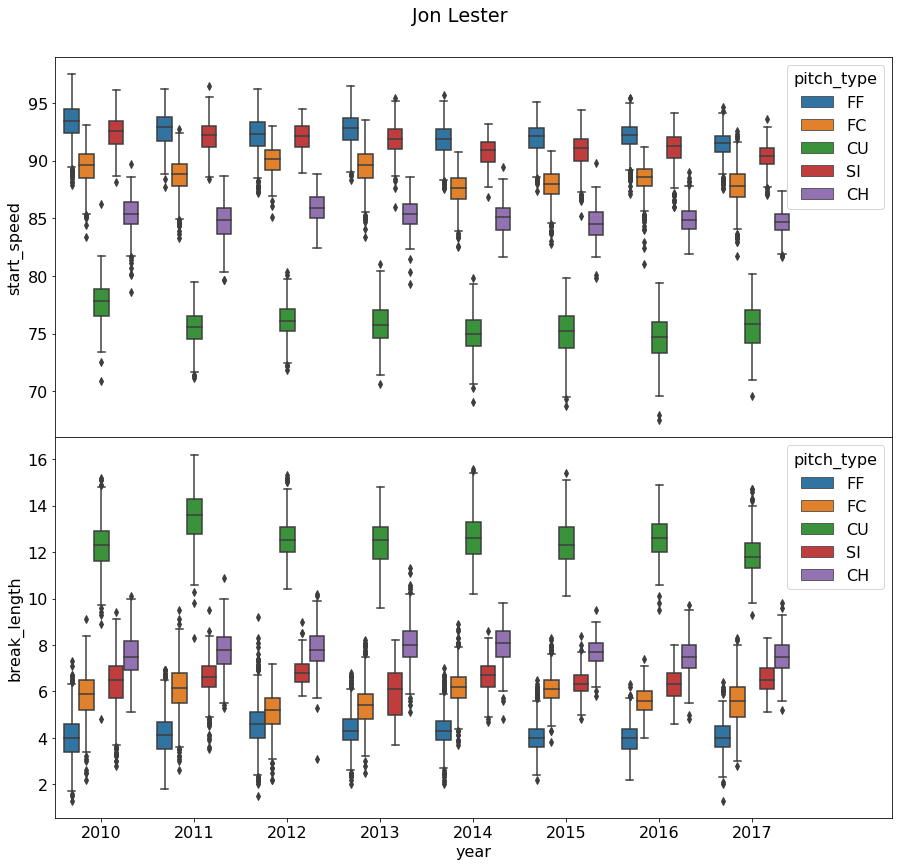

In [8]:
#features = ['start_speed','spin_rate','spin_dir','pfx_z','break_angle','break_length']
features = ['start_speed','break_length']
box_plots('year',features,'pitch_type',pfx.df)

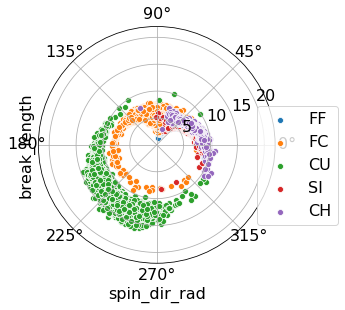

In [9]:
## radial plots

pfx.df['spin_dir_rad'] = (pfx.df.spin_dir-90)*np.pi/180

# Set up a grid of axes with a polar projection
g = sns.FacetGrid(pfx.df,hue="pitch_type",
                  subplot_kws=dict(projection='polar'), height=4.5,
                  sharex=False, sharey=False, despine=False)

# Draw a scatterplot onto each axes in the grid
a = g.map(sns.scatterplot, "spin_dir_rad", "break_length")
plt.legend(bbox_to_anchor=(1.3, 0.7))

In [10]:
## year and pitcher to analyze
year = 2016
pitcher = 'hendk001'
pfx = get_season(year, pitcher)
pfx.df = pfx.df[(pfx.df.pitch_type!='PO') & (pfx.df.pitch_type!='IN')]

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


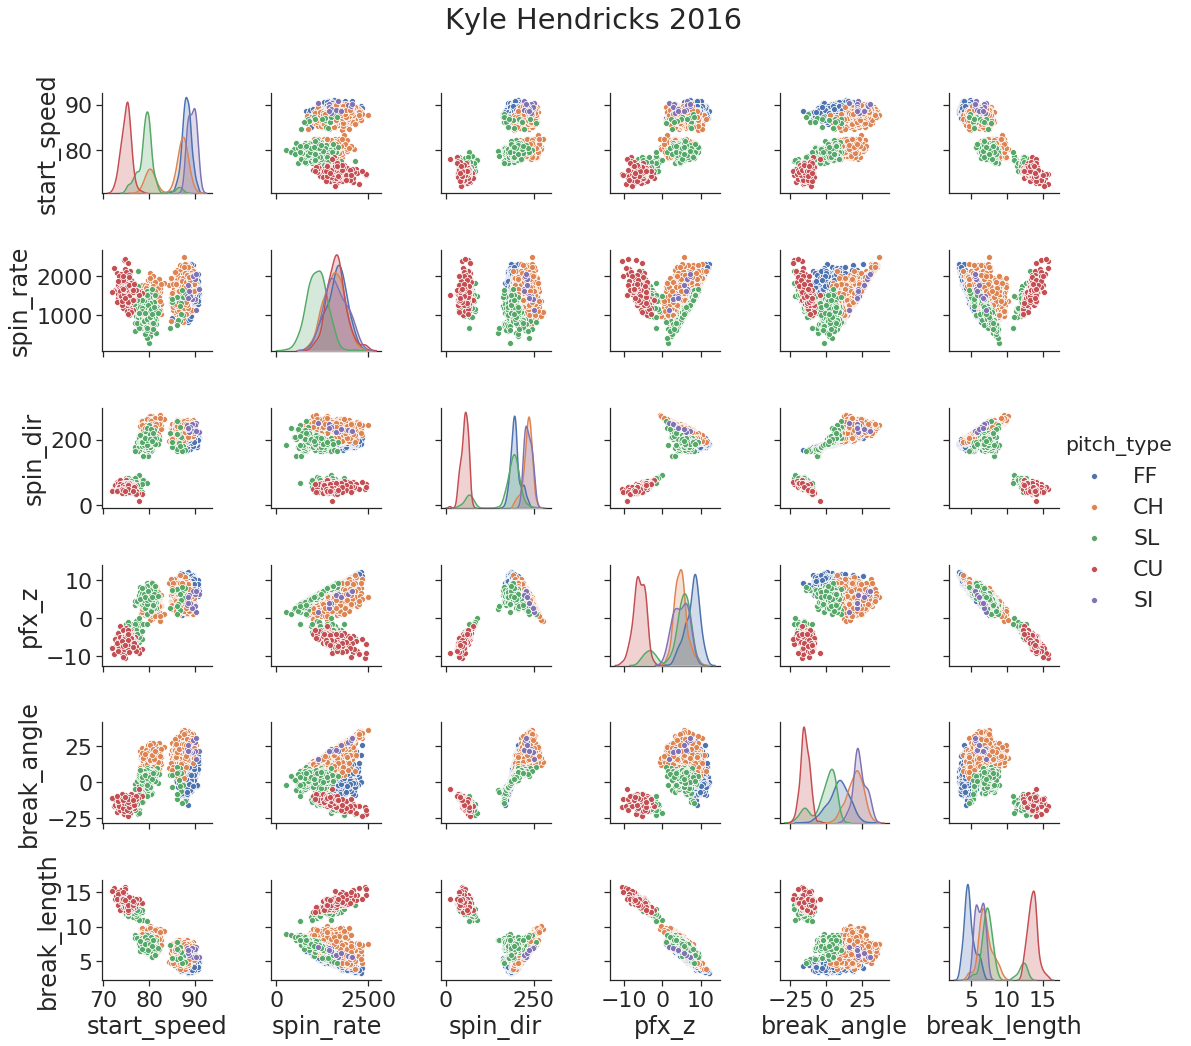

In [11]:
## have a look at relationships between continuous variables
## by pitch type
## set plot parameters
tmp = plt.rc('font', size=16)
fig = plt.figure(figsize=(15,10))
tmp = sns.set(style="ticks", font_scale=2)
## scatter matrix
sns_plot = sns.pairplot(pfx.df[['start_speed','spin_rate','spin_dir','pfx_z','break_angle','break_length','pitch_type']],
                        hue="pitch_type")

sns_plot.fig.suptitle(pfx.df.retro_name.unique()[0]+" "+str(year))
sns_plot.fig.subplots_adjust(top=.9)
out_file_name = '-'.join(pfx.df.retro_name.unique()[0].lower().split())+'-'+str(year)+'.png'
sns_plot.savefig('figs/'+out_file_name)


In [12]:
## split frames by pitch type for further investigation
pitch_types = pfx.df['pitch_type'].dropna().unique()
frames_by_type = [pfx.df[pfx.df['pitch_type']==pitch] for pitch in pitch_types]

In [13]:
## for making individual scatter plots
def make_scatter_by_type(x, y):
    """Function to show 2d scatter plots of variables x and y (given as strings)"""
    fig = plt.figure(figsize=(15,10))
    for it in range(len(pitch_types)):
        plt.scatter(frames_by_type[it][x],frames_by_type[it][y], label=pitch_types[it], s=100)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

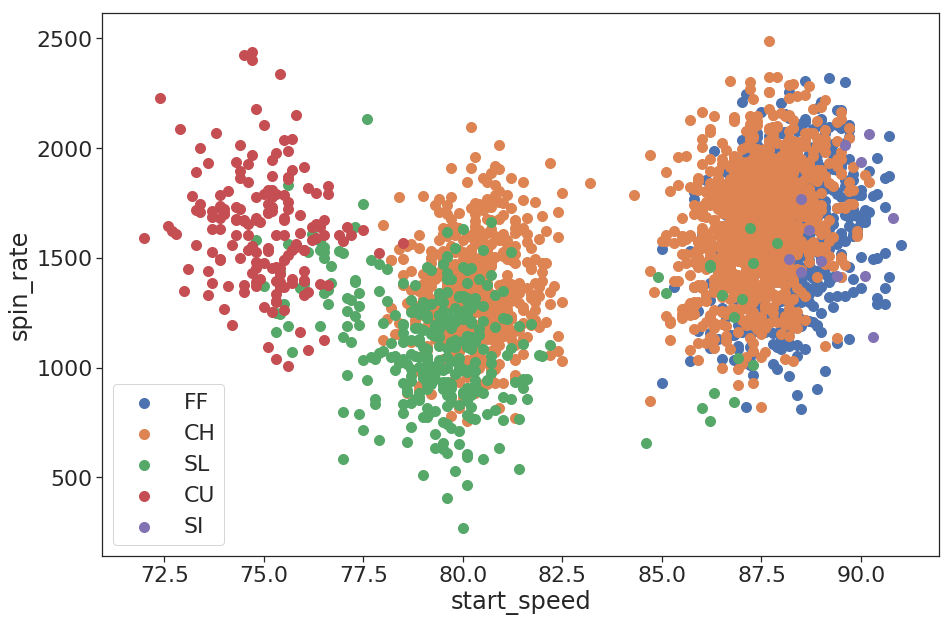

In [14]:
make_scatter_by_type('start_speed','spin_rate')